## 概要
神经网络conv layer的运行机制和神经网络的训练状况分析.

* 使用nn.Conv2d来构建一个用来识别数字的简单cnn
* 在训练时颜色空间的转换一般没有意义
* 使用ActivationStats来监控训练时每一层output的mean, std, near_zero, 以便及早发现存在的问题.
* 通过调整learning rate和batch size, fit_one_cycle来优化训练的稳定性

## Init fast ai

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.all import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 KB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 12.1 MB/s eta 0:00:00
Mounted at /content/gdrive


## Data



In [2]:
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path
path.ls()

(#2) [Path('testing'),Path('training')]

## Train Simple CNN

### 数据加载和检查

In [3]:
def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),  # PILImageBW, black and white?
        get_items=get_image_files, 
        splitter=GrandparentSplitter('training','testing'), # splitter by folder name
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()

获取一个batch的训练数据进行检查, 包含train image 和 result的tuple

In [4]:
batch_0 = dls.one_batch()
batch_0[0].shape, batch_0[1].shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

总共的图片数量

In [5]:
len(dls.items)

60000

显示图片

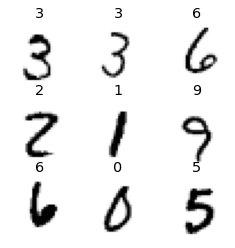

In [6]:
dls.show_batch(max_n=9, figsize=(4,4))

### 定义cnn模型

Define a simple cnn model.

channel是指通道, 只有stride和padding会影响输出tensor的with, height.

torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)

In [7]:
def simple_cnn():
    return sequential(
        nn.Sequential(nn.Conv2d(1, 8, stride=2, kernel_size=5, padding=5//2), nn.ReLU()), #14 x14
        nn.Sequential(nn.Conv2d(8, 16, stride=2, kernel_size=3, padding=3//2), nn.ReLU()), #7x7
        nn.Sequential(nn.Conv2d(16, 32, stride=2, kernel_size=3, padding=3//2), nn.ReLU()), #4x4
        nn.Sequential(nn.Conv2d(32, 64, stride=2, kernel_size=3, padding=3//2), nn.ReLU()), #2x2
        nn.Conv2d(64, 10, stride=2, kernel_size=3, padding=3//2), # 1x1
        Flatten(), # torch.nn.Flatten(start_dim=1, end_dim=- 1)， 将对应维度展开, 默认展开为2维
    )

### 通过ActivationStats来分析训练结果

通过加入`ActivationStats`来查看训练时模型每一层的输出结果的分布: mean,std,near_zero(值接近于0, 若是这一层几乎都输出0, 说明模型/训练有问题).

In [8]:
learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy, metrics=accuracy, cbs=ActivationStats(with_hist=True))
learn.fit(1, 0.06)

/usr/local/lib/python3.8/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.306444,2.306199,0.113500,01:27


查看`ActivationStats`结果

我们期望的是一个稳定的(变化不大的), 至少平滑渐变的 `mean`, `std`, `near_zero`. `near_zero` 比例不能太大. 这里的结果显然不是我们想要的.

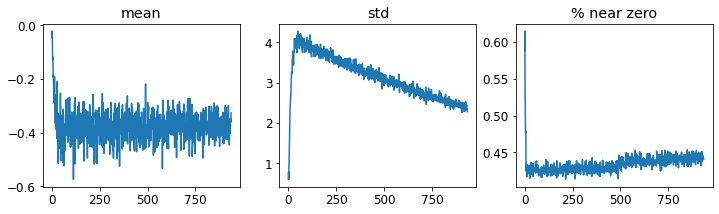

In [9]:
# plots the mean and standard deviation of the activations of layer number idx
learn.activation_stats.plot_layer_stats(0)

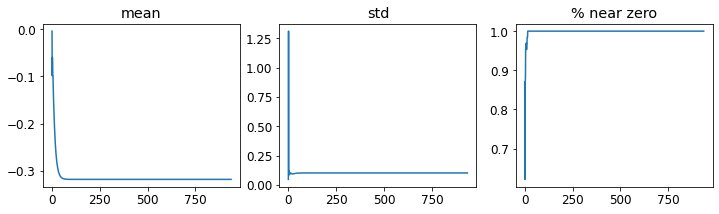

In [10]:
learn.activation_stats.plot_layer_stats(-2)

#### color_dim图

color_dim 的基本思想是, 每一层的输出的理想状态下是一个平滑的分布.

The basic idea is to create a histogram of the activations of a layer, which we would hope would follow a smooth pattern such as the normal distribution (colorful_dist).

![colorful_dist](https://docs.google.com/uc?id=1bh1s4frAIQTIPcPfYp0rqgMrOH--Kiss)

纵轴表示`activation value`, 横轴表示训练的batch, 用颜色来表示该activation value的数量占比. 在colorful dimension中, 使用对histogram value取log更清晰.

The idea of the colorful dimension is to express with colors the mean and standard deviation of activations for each batch during training. Vertical axis represents a group (bin) of activation values. Each column in the horizontal axis is a batch. The colours represent how many activations for that batch have a value in that bin.
![colorful_dimension](https://docs.google.com/uc?id=1qijq4eSpzyP5IsEl8hlBssDfNjZlu9-O)



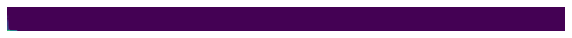

In [14]:
learn.activation_stats.color_dim(-2)

这张color_dim图是一个训练失败的经典案例. 

开始时activation value基本上都是0, 随着时间为0的比例下降(感觉像是训练又重新开始一样), 重复几次后, 回归正常.

一般来说, 我们期望的是一个平滑的变变化, 指数地增长然后崩溃下降, 往往会出现很多激活为0的情况, 这也意味着训练缓慢, 结果不理想. 一种方式是添加BN.

This shows a classic picture of "bad training." We start with nearly all activations at zero—that's what we see at the far left, with all the dark blue. The bright yellow at the bottom represents the near-zero activations. Then, over the first few batches we see the number of nonzero activations exponentially increasing. But it goes too far, and collapses! We see the dark blue return, and the bottom becomes bright yellow again. It almost looks like training restarts from scratch. Then we see the activations increase again, and collapse again. After repeating this a few times, eventually we see a spread of activations throughout the range.

![classic_training_fail](https://docs.google.com/uc?id=1B9adyEf-DzeqkxzjRMRGY80CPKaM00Vy)

## 训练优化的技巧

#### 选取合适的learning rate

SuggestedLRs(valley=0.002511886414140463)

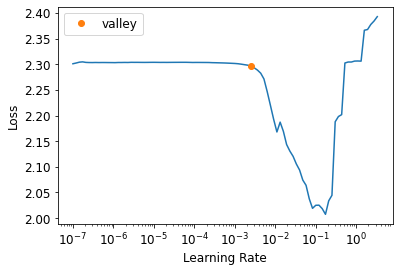

In [15]:
dls = get_dls(64)
learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy, metrics=accuracy, cbs=ActivationStats(with_hist=true))
learn.lr_find()

In [16]:
learn.fit(1, 0.0025)

epoch,train_loss,valid_loss,accuracy,time
0,0.097470,0.071190,0.977200,01:17


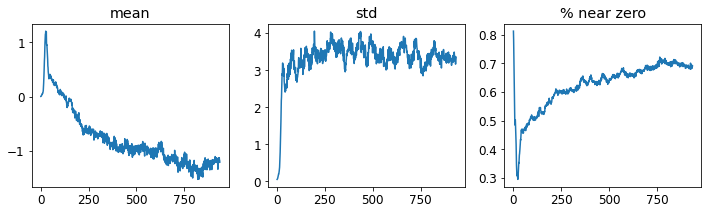

In [17]:
learn.activation_stats.plot_layer_stats(-2)

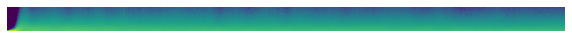

In [18]:
learn.activation_stats.color_dim(-2)

#### 通过加大batch size, 来使得训练更稳定.
这里主要是learning rate的问题, 感觉基本没效果.

/usr/local/lib/python3.8/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


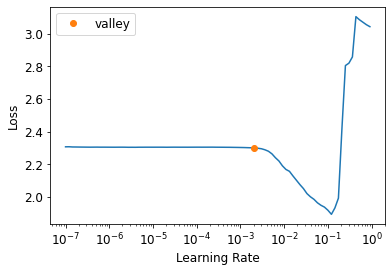

In [ ]:
dls = get_dls(128)
learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy, metrics=accuracy, cbs=ActivationStats(with_hist=true))
lr = learn.lr_find()

In [ ]:
learn.fit(1, lr.valley)

epoch,train_loss,valid_loss,accuracy,time
0,0.115806,0.091144,0.971100,01:18


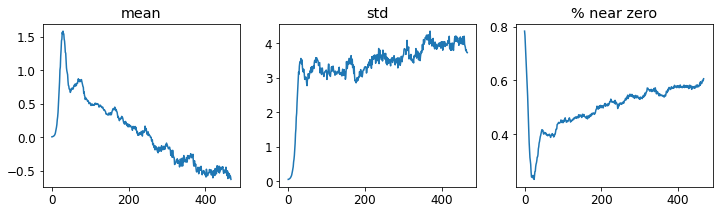

In [ ]:
learn.activation_stats.plot_layer_stats(-2)

#### 利用1cycle training来提高训练效率
"Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates".

相对而言fit_one_cycle策略对输入的learning_rate更友好

In [ ]:
learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy, metrics=accuracy, cbs=ActivationStats(with_hist=true))
learn.fit_one_cycle(1, 0.06)

/usr/local/lib/python3.8/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.133813,0.102376,0.969900,01:12


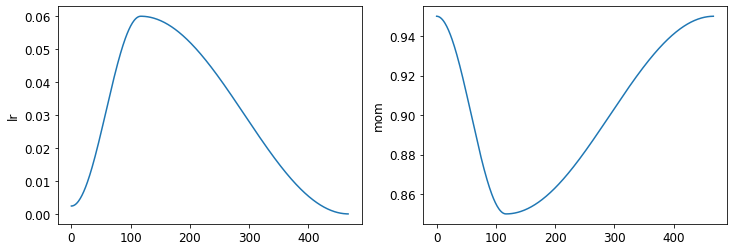

In [ ]:
learn.recorder.plot_sched()

### Add Batch Normalization


[Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)

机器学习在输入数据由均值为0, 单位方差的不相关特征构成的时候往往表现得更好, 但随着网络的训练, 每层的weight在不断更新, 导致后面layer的输入数据会发生偏移, 不再具有均值为0或单位方差, 而数据进入网络前, 进行数据预处理解决不了这个问题. 所以提出了Batch Normalization.

定义添加BN的CNN模型
TODO

In [21]:
def simple_cnn_with_BN():
    return sequential(
        # nn.BatchNorm2d(output_channel_size)
        nn.Sequential(nn.Conv2d(1, 8, stride=2, kernel_size=5, padding=5//2), nn.ReLU(), nn.BatchNorm2d(8)), #14x14
        nn.Sequential(nn.Conv2d(8, 16, stride=2, kernel_size=3, padding=3//2), nn.ReLU(), nn.BatchNorm2d(16)), #7x7
        nn.Sequential(nn.Conv2d(16, 32, stride=2, kernel_size=3, padding=3//2), nn.ReLU(), nn.BatchNorm2d(32)), #4x4
        nn.Sequential(nn.Conv2d(32, 64, stride=2, kernel_size=3, padding=3//2), nn.ReLU(), nn.BatchNorm2d(64)), #2x2
        nn.Conv2d(64, 10, stride=2, kernel_size=3, padding=3//2), # 1x1
        Flatten(), # torch.nn.Flatten(start_dim=1, end_dim=- 1)， 将对应维度展开, 默认展开为2维
    )
learn = Learner(dls, simple_cnn_with_BN(), loss_func=F.cross_entropy, metrics=accuracy, cbs=ActivationStats(with_hist=true))
learn.fit_one_cycle(1, 0.06)

epoch,train_loss,valid_loss,accuracy,time
0,0.052982,0.044438,0.986900,01:22


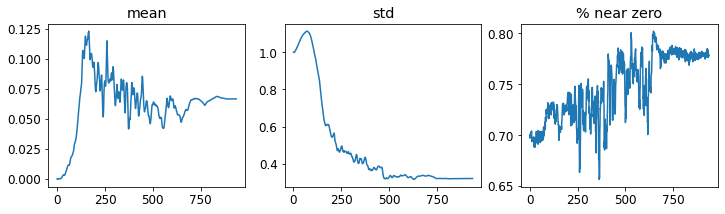

In [22]:
learn.activation_stats.plot_layer_stats(-2)

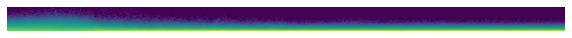

In [23]:
learn.activation_stats.color_dim(-2)